# Project 5: Image Recognition with Convolutional Neural Networks

## Introduction

In this exercise, we will use Convolutional Neural Networks to implement an algorithm that can distinguish between dog breeds from images.

First, we will use the `fastai` library to classify images of dogs and cats.

Next, we will perform the task of distinguishing dogs of different breeds by implementing a neural network in PyTorch.

Finally, we will apply the Transfer Learning technique to implement an algorithm that can classify images of dogs of different breeds.

In [41]:
import os
import numpy as np
import time
import torch
from matplotlib import pyplot
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch import nn
from torch import optim
import utils

%matplotlib inline

In [ ]:
train_on_gpu = torch.cuda.is_available()  
if train_on_gpu:
    device = torch.device("cuda")  
    print("Training on GPU.")
else:
    device = torch.device("cpu")
    print("GPU unavailable, training on CPU.")

## 1 FastAI

FastAI is a Machine Learning library that aims to simplify the creation of neural networks as much as possible, making it possible to implement efficient artificial intelligence algorithms quickly and easily. FastAI is expected to be installed on your system.

`pip install git+https://github.com/fastai/fastai.git`

In [29]:
import fastai.vision.all as fst

### 1.1 Downloading the dataset

We will start the execution by collecting the path (*path*) of the directory in which the dataset is located. To do this, we will use the `fst.untar_data()` function with `fst.URLs.PETS` as a parameter. The variable `fst.URLs.PETS` contains the link to a dataset whose contents are images of cats and dogs of various breeds. The `fst.untar_data()` function downloads these images and returns a variable of type `Path` with the directory in which these images were downloaded. Note that we have concatenated this path with `'images'` so that we can enter this directory to access all the images in the dataset.

In [30]:
path = fst.untar_data(fst.URLs.PETS) / "images"

### 1.2 Data visualization

With the directory path specified, we can access it to collect the list of images within it, using the `fst.get_image_files()` function. We'll print out the first 10 elements of this list to understand what it's about and then calculate its length, so we know the size of our dataset.

In [ ]:
# Get list of files
files = list(fst.get_image_files(path))
files[:10]

In [ ]:
print("Number of images:", len(files))

Our dataset therefore consists of 7390 images of cats and dogs. This is the data we are going to use to train and test the neural network we are going to set up. To understand what the images look like, we'll use the `fst.PILImage.create()` function to display one of the images in the `files` variable.

In [ ]:
from random import randint

fst.PILImage.create(files[randint(0, 7390)])

Going back to the `files` variable, notice that the cat images are saved in files whose names start with an uppercase letter, while the dog images are in files whose names start with a lowercase letter. This was done so that it would be possible to differentiate the images by file name alone, since it is this differentiation that will be used to produce the labels for each image. The `is_cat()` function, created in the cell below, returns a boolean that indicates whether the first letter of the input variable is uppercase (in this case, `True`) or lowercase (`False`).

In [34]:
def is_cat(x):
    return x[0].isupper()

To finish processing our data, we'll create a Dataloader using the `fst.ImageDataLoaders.from_name_func()` function from the *fastai2* library. The function parameters are:

- `path`: indicates the directory in which the algorithm should work.
- `fnames`: receives the list with the directories and names of all the images that will be incorporated into the DataLoader.
- `valid_pct`: determines the size of the validation dataset (in this case, valid_pct=0.2 means that 20% of the dataset will be used for validation).
- `seed`: chooses any number to ensure that the exercise is reproduced with the same results.
- `label_func`: specifies the function that will identify the label of each example in the dataset, in our case, the `is_cat()` function defined in the cell above.
- `item_tfms`: specifies which transformations will be applied to each image in the dataset, the most common of which is resizing(*resize*).

In [35]:
# Load data into fastai
dls = fst.ImageDataLoaders.from_name_func(  # Structure of dataset
    path=path,  # Working directory
    fnames=files,  # List of files
    valid_pct=0.2,  # Size of validation set
    seed=42,  # Random number seed
    label_func=is_cat,  # Helper function for labels
    item_tfms=fst.Resize(224),
)  # Data transformations

As mentioned above, the `seed` parameter works to guarantee the reproducibility of a random process, but how does this work?

In fact, algorithms can't produce truly random processes, but so-called pseudo-random processes. These processes are mathematical functions that use other variables (usually the time) to produce sequences that appear random. Setting a value for the `seed` parameter makes the variable used the indicated value, so that the sequence of values generated will always be the same.

### 1.3 Creating and training the neural network

With all the dataset processed, we can create our neural network. To do this, we will use the *transfer learning* technique, using a ResNet, a pre-trained residual neural network.

In [36]:
# Create a fastai "learner"
learn = fst.cnn_learner(  # Helper function to create learner for CNNs
    dls=dls, arch=fst.resnet34  # Previously created dataloaders
)  # Pretrained model architecture

With ResNet34 and the `dls` dataloader selected, we can start training our neural network. To do this, we will use the `fine_tune()` function with the chosen number of epochs. As the dataset is relatively large and the network is already pre-trained, we won't need many epochs, so we've chosen to train our network for just 3 epochs.

In [ ]:
epochs = 3

# Train the model (fine-tuning)
learn.fine_tune(3)

### 1.4 Testing the neural network

Now we will test our trained network. To do this, we will use the `ipywidgets` library, which will allow us to upload any image saved on our computers.
Choose two images of your choice, one with a cat in it and one with a dog, and run the test. Run the cell below to generate a field where you can upload images that will be used to test our neural network. At first, upload a picture of a cat.

In [ ]:
# Test with cat
from ipywidgets import widgets

uploader1 = widgets.FileUpload()
print("Upload an image containing a cat")
uploader1

Once uploaded, we can visualize the image and then use it as input for the neural network.

In [ ]:
img1 = fst.PILImage.create(uploader1.data[0])
img1.to_thumb(200)

In [ ]:
is_cat, _, probs = learn.predict(img1)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability of being a cat: {100* probs[1].item():.6f}%")

Now we'll do the same process, but with an image of a dog.

In [ ]:
uploader2 = widgets.FileUpload()
print("Upload an image containing a dog")
uploader2

In [ ]:
img2 = fst.PILImage.create(uploader2.data[0])
img2.to_thumb(400)

In [ ]:
is_cat, _, probs = learn.predict(img2)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability of being a cat: {100* probs[1].item():.6f}%")

We then have a neural network trained to distinguish images of dogs from images of cats with significantly high accuracy. This is one of the best-known applications of what we call “computer vision”.

The machine learning model adopted in this exercise is called *Transfer Learning*, and it is highly powerful. It basically consists of taking a pre-trained neural network (in this case ResNet34) and re-training it to perform a specific function (in this case distinguishing images of dogs from images of cats) from a new dataset (in this case the 7390 images of dogs and cats provided).

Our aim in presenting this exercise is to offer a new tool for various applications. We invite you to modify the original parameters of this notebook (such as the number of epochs, the size of the validation set, etc.) to see the consequences of each change.

Subsequently, you can also provide a new dataset to train the network to perform a new function, such as distinguishing whales from dolphins, motorcycles from cars, x-rays from broken bones from intact ones, etc.

## 2 CNN for binary image classification

Now immersed in the problem of distinguishing between dog breeds, we will implement another convolutional neural network to identify two dog breeds, now using the Pytorch library. This library has already been presented to you in Programming Challenge 3, and will now be explored in more depth.

We'll use the following modules necessary for **building** the neural network, remembering that they were already imported at the start of the Jupyter Notebook.

* The `torch` library;
* `transforms` from the `torchvision.transforms` module;
* `ImageFolder` from the `torchvision.datasets` module;
* `DataLoader` and `random_split` from the `torch.utils.data` module.

In addition to PyTorch, you'll notice that we've also imported some elements from the torchvision library. In fact, although it is imported separately, torchvision is part of Pytorch and is nothing more than a library that allows us to import pre-trained models and classic datasets that have already been assembled, as well as providing tools to help structure the data that will be used in the neural network in question. In this activity, we will only use torchvision to organize our data which will be inserted into the neural network we will also create.

### 2.1 Dataset processing

The data to be used has already been downloaded into the “Data” folder and will be imported into the data variable in the cell below.

In [44]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
data = ImageFolder("data/Duas", transform=transform)

The first line of the cell above defines the `transform` variable using the `transforms.Compose` function, which performs a composition of all the transformations that are within the list that is passed as its only parameter. In this case, the only two transformations are resizing the image to 224 pixels (`transforms.Resize(224)`) and transforming this image into a tensor (`transforms.ToTensor()`). Please note that the number 224 was just a standard adopted, but other values are also valid. To access other transformations provided by this library, [click on this link](https://pytorch.org/docs/stable/torchvision/transforms.html).

Next, we use the `ImageFolder` function to collect the images in the directory passed as a parameter and save them in a dataset. For this function to work, we must separate our examples into folders whose names will be used as the labels of the images inside their respective folders.

Once the dataset has been imported, we can see the size of the dataset.

We will now split the training and test datasets. The division will initially be as follows:

- Training dataset: will consist of approximately 75% of the data.
- Test dataset: the rest of the data.

To perform the division, we will use the `random_split()` function. Note that we will ensure reproducibility by using the same technique as in section 1.2 of this task, specifying a `seed` value (in this case, 42).

In [ ]:
print("Total images in the dataset:", len(data))
percentage = 75
n_treino = round(len(data) * (percentage / 100))
n_teste = round(len(data) * (100 - percentage) / (2 * 100))
n_valid = len(data) - n_treino - n_teste

print(
    "Number of images for training: {:}".format(n_treino)
    + "; Number of test images: {:}".format(n_teste)
    + "; Number of images for validation: {:}".format(n_valid)
    + "."
)
data_train, data_test, data_valid = random_split(
    data, [n_treino, n_teste, n_valid], generator=torch.Generator().manual_seed(42)
)

batch_size = 20
loader_train, loader_test, loader_valid = (
    DataLoader(data_train, batch_size=batch_size),
    DataLoader(data_test, batch_size=1),
    DataLoader(data_valid, batch_size=1),
)

Note that we have used the `round()` function to prevent multiplication from resulting in a non-integer number, rounding to the nearest integer.

See also the creation of the training and test *dataloaders* using the `DataLoader` functionality. This is important so that we can combine examples and labels in iterations, as well as dividing the training data into *batches*.

We chose the initial *batch_size* value of 20, but the choice of this value is not rigid and there is no ready-made formula for it. Therefore, as soon as we finalize our neural network, we recommend that you modify the value of this parameter and see what changes occur in the training and testing process.

### 2.2 Assembling a Neural Network with PyTorch

We will now set up the neural network that will be used for classification. The network will be structured as follows:

#### *Input Layer*

- One layer:
  - Layer with 3 input channels, 224x224 each.

#### *Feature Mapping Layers*

- Three sets of  convolution/*pooling*, totaling six layers; All layers will have the same filter:
  - **Convolutional filter:** *kernel size* of 4x4, *stride* equal to 2 and *padding* equal to 1.
  -   Pooling filter:** *kernel size* of 2x2 and *stride* equal to 2.

- First set:
  - The first convolution layer should have 3 input channels and 8 output channels, resulting in 8 channels of dimension 112x112;
  - The first *pooling* layer will reduce the size of each channel to 56x56;
    
- Second set:
  - The second convolution layer should have 8 input channels and 16 output channels, resulting in 16 channels of dimension 28x28;
  - The second *pooling* layer will reduce the dimension of each channel to 16x16;
   
- Third set:
  - The third convolution layer should have 16 input channels and 32 output channels, resulting in 32 channels of dimension 8x8;
  - The third *pooling* layer will reduce the size of each channel to 4x4;
  
#### *Fully Connected Layers*

- Three layers:
  - The first layer must have 512 *hidden units*;
  - The second layer must have 128 *hidden units*.
  - The third layer must have 16 *hidden units* .

#### *Output Layer*

- One layer:
  - Layer with 2 *outputs*


The above architecture is illustrated in the diagram below:

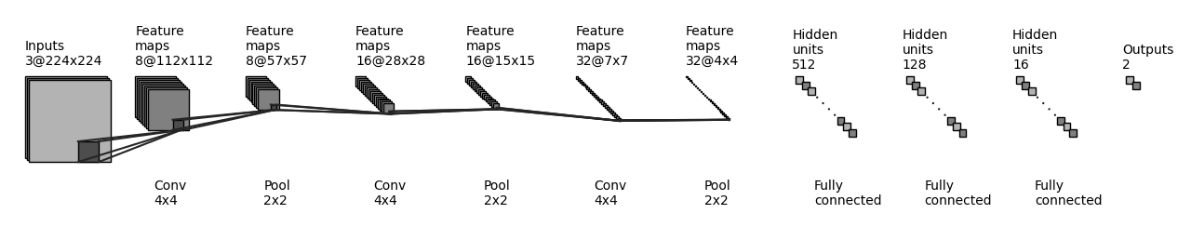

In [46]:
class NN_CNN(torch.nn.Module):
    def __init__(self, altura_imagem, largura_imagem, n_layer=3):
        super(NN_CNN, self).__init__()
        self.kernel_size_conv = 4
        self.stride_conv = 2
        self.padding_conv = 1
        self.dilation_conv = 1

        self.kernel_size_pool = 2
        self.stride_pool = 2
        self.padding_pool = 1
        self.dilation_pool = 1

        self.altura_imagem = altura_imagem
        self.largura_imagem = largura_imagem

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=self.kernel_size_conv,
                stride=self.stride_conv,
                padding=self.padding_conv,
                dilation=self.dilation_conv,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(
                kernel_size=self.kernel_size_pool,
                stride=self.stride_pool,
                padding=self.padding_pool,
                dilation=self.dilation_pool,
            ),
        )

        self.layer2 = 0
        self.layer3 = 0

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=self.kernel_size_conv,
                stride=self.stride_conv,
                padding=self.padding_conv,
                dilation=self.dilation_conv,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(
                kernel_size=self.kernel_size_pool,
                stride=self.stride_pool,
                padding=self.padding_pool,
                dilation=self.dilation_pool,
            ),
        )

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=self.kernel_size_conv,
                stride=self.stride_conv,
                padding=self.padding_conv,
                dilation=self.dilation_conv,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(
                kernel_size=self.kernel_size_pool,
                stride=self.stride_pool,
                padding=self.padding_pool,
                dilation=self.dilation_pool,
            ),
        )

        self.dicio = {}
        self.dicio[0] = self.layer1
        self.dicio[1] = self.layer2
        self.dicio[2] = self.layer3

        self.size_list = [(altura_imagem, largura_imagem)]
        self.num_list, self.patch_size_list = [], []
        altura, largura = altura_imagem, largura_imagem
        for n in range(n_layer):
            self.conv_altura = (
                1
                + (
                    altura
                    + 2 * self.padding_conv
                    - self.dilation_conv * (self.kernel_size_conv - 1)
                    - 1
                )
                // self.stride_conv
            )
            self.conv_largura = (
                1
                + (
                    largura
                    + 2 * self.padding_conv
                    - self.dilation_conv * (self.kernel_size_conv - 1)
                    - 1
                )
                // self.stride_conv
            )
            altura = (
                1
                + (
                    self.conv_altura
                    + 2 * self.padding_pool
                    - self.dilation_pool * (self.kernel_size_pool - 1)
                    - 1
                )
                // self.stride_pool
            )
            largura = (
                1
                + (
                    self.conv_largura
                    + 2 * self.padding_pool
                    - self.dilation_pool * (self.kernel_size_pool - 1)
                    - 1
                )
                // self.stride_pool
            )

            self.size_list.append((self.conv_largura, self.conv_altura))
            self.num_list.append(self.dicio[n][0].in_channels)
            self.size_list.append((altura, largura))
            self.num_list.append(self.dicio[n][0].out_channels)
            self.patch_size_list.append((self.kernel_size_conv, self.kernel_size_conv))
            self.patch_size_list.append((self.kernel_size_pool, self.kernel_size_pool))

        self.num_list.append(self.num_list[-1])

        self.fc1 = torch.nn.Linear(32 * 4 * 4, 128)
        self.fc2 = torch.nn.Linear(128, 16)
        self.fc3 = torch.nn.Linear(16, 2)

        self.num_fc_list = []
        self.num_fc_list.append(self.fc1.in_features)
        self.num_fc_list.append(self.fc2.in_features)
        self.num_fc_list.append(self.fc3.in_features)
        self.num_fc_list.append(self.fc3.out_features)

With the structure of our neural network set up, we will use the `cria_imagem()` function provided in the `utils` file to produce an image with the layout of the neural network built in the cell above. If the structure seen in the image is different from the one shown above, there is probably an error in the implementation of the upper cell.

In [ ]:
model = NN_CNN(224, 224)
utils.cria_imagem(model)
model

With the network built, we must implement the `forward()` function, which will take as input an image of 3 channels, each 224x224 in size, pass this image through the 3 sets of layers of the neural network and then pass the result through the three *fully connected* layers. This result must be saved in the `out` variable, which is returned at the end of the function.

In [48]:
def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = torch.flatten(x, 1)
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    out = self.fc3(x)
    return out

With the function ready, we will instantiate the neural network in the `model` variable by executing the cell below and adding the `forward` function to it using the `types.MethodType()` function.

In [49]:
model = NN_CNN(altura_imagem=224, largura_imagem=224).to(device)

import types

model.forward = types.MethodType(forward, model)

With the neural network correctly configured and the `forward()` function properly implemented, we can train and test our function.

Notice that the model variable that was loaded into the cell above is not loaded again into the cell below. This means that the variables used in the cell below are not reloaded each time the cell is executed, allowing the same model to be trained and tested for more times, starting from where it left off. If you want to restart the process, training a model from scratch by resetting the `model` variable, run the cell above.

In [ ]:
epochs = 30
lr = 0.0025

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

list_train_loss = []
list_test_loss = []
list_acc = []
for epoch in range(1, epochs + 1):
    model.train()
    for imagem_treino, label_treino in loader_train:
        imagem_treino, label_treino = imagem_treino.float().to(device), label_treino.to(
            device
        )
        outputs = model(imagem_treino)
        outputs = torch.log_softmax(outputs, dim=1)
        loss = criterion(outputs, label_treino.float().long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    list_train_loss.append(loss.item())

    correct = 0
    total = 0
    model.eval()
    for imagem_teste, label_teste in loader_test:
        imagem_teste, label_teste = imagem_teste.float().to(device), label_teste.to(
            device
        )
        outputs_test = model(imagem_teste)
        outputs_test = torch.log_softmax(outputs_test, dim=1)
        _, previsao = torch.max(outputs_test, dim=1)
        loss_test = criterion(outputs_test, label_teste.long())
        total = total + 1
        if previsao == label_teste:
            correct = correct + 1
    list_test_loss.append(loss_test.item())

    acc = (correct / total) * 100
    list_acc.append(acc)

    print(
        "epoch:",
        epoch,
        " loss: {:.4f}".format(loss.item()),
        " Accuracy: {:.2f}".format(acc),
    )

By training and testing our model, we can analyze the behavior of cost and accuracy over time.

In [ ]:
fig, axs = pyplot.subplots(2, figsize=(15, 8))
axs[0].plot(list_train_loss, label="Train loss")
axs[0].plot(list_test_loss, label="Test loss")
axs[0].set_title("Losses x Epochs")
axs[0].set(xlabel="Epochs")
axs[0].set(ylabel="Losses")
axs[0].legend()
axs[0].grid(True)


axs[1].plot(list_acc, label="Accuracy")
axs[1].set_title("Accuracy x epochs")
axs[1].set(xlabel="Epochs")
axs[1].set(ylabel="Accuracy (%)")
axs[1].legend(loc="lower right")
axs[1].grid(True)

pyplot.tight_layout()

We suggest modifying the parameters used to train the network. The values to be tested are as follows (in that order):

  a) *Batch Size* (variable `batch_size`): [10, 50, 100, 500];
  
  b) Percentage *Training_Set*/*Full_dataset* (variable `percentage`): [70, 80, 90].

  c) *Learning Rate* (variable `lr`): [0.0005, 0.001, 0.005, 0.01, 0.05];

  d) *Epochs* (variable `epochs`): [5, 20, 40, 60].

To do this, please follow these instructions:

1. modify only one of the parameters under test, leaving the others with their values *defaults*.

2. Assign the requested values to the parameter under test, respecting the designated order.

3. Rerun all the cells starting from the one that was changed, with the value of the parameter under test modified. Remember to reset your `model` variable.

4. Note the differences in execution time and accuracy.

5. Repeat the procedure with the next value (or the next parameter) to be tested.

6. When all the tests are finished, assign the *default* values back to the modified parameters.


### 2.3 Importing a pre-trained network

In the previous activity we implemented a CNN that could distinguish images of dog breeds. Now, we're going to look at the same problem, but we'll do it with other tools.

In the previous task, we entirely created the structure of the CNN. Now, we will use the concept of Transfer Learning, importing the pre-trained ResNet18 Neural Network to do the classification in question.

The aim is to compare the gains and losses that this technique brings us in solving this problem.

With the data loaded into the `data` variable from the previous activity, we will divide the dataset into training and test portions.

Unlike the last task, we will not create our own neural network model. This time, we will import a pre-trained model, in this case the one chosen was `ResNet18` because of its simplicity and efficiency.

To do this, we will use the `models` module of the `torchvision` library by executing the cell below. This module provides several pre-trained neural networks of different types.

As said, the one chosen was a ResNet, specifically `Resnet18`. Of all the ResNets available, this is the one with the simplest structure, and therefore requires the least memory and time for training and testing.

In [ ]:
model = models.resnet18(pretrained=True)

To see the structure of the chosen network, we'll run the cell below.

In [ ]:
model

Transfer learning is a technique that allows us to use a network whose parameters have already been trained using large and diverse datasets. However, the structure of the network does not always fit the context in which we are going to use it. For example, the *output* layer of ResNet18 has a thousand units but, for our problem, we only need two output units.

To solve this, we can modify the network layers as we wish. For this example, we are only interested in modifying the last layers of the network, called *fully connected layers* (or `fc`).

Before making any changes to the network architecture, we can disable the Pytorch functionality that automatically calculates the gradients of the network parameters. We'll do this because we don't want to update the parameters of the convolutional part of the network, as they will be “frozen” for this application. This is not strictly necessary, but it reduces the computational cost of the algorithm and saves us a lot of time.

Note: as we changed the last layers of the network **after** deactivating the gradient calculation for the network parameters, the new parameters enter with the gradient calculation activated by *default* from Pytorch, allowing us to train them next.

In [54]:
# Freeze our model parameters
for param in model.parameters():
    param.requires_grad = False

# Change the architecture of the classifier portion of the CNN
classifier = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1),
)

model.fc = classifier

As explained, we only changed the fully connected portion of the network, which is responsible for classifying the examples. The convolutional layers, which are responsible for feature extraction from the inputs, have been left “frozen”. To visualize the new network architecture, we'll run the cell below.

In [ ]:
model

We then define some important parameters for training the network, and initialize some variables that we will use during training.

These parameters were chosen after some tests we carried out and were the ones that gave the best results when training the network.

In [56]:
epochs = 5
lr = 0.001

criterion = nn.NLLLoss()

optimizer = torch.optim.AdamW(model.fc.parameters(), lr=lr)

list_train_loss = []
list_test_loss = []
list_acc = []

model = model.to(device)

Note that we chose the *Adaptive Moment Estimation with Decoupled Weight Decay* (AdamW) algorithm as the optimizer. This optimizer is an alternative to the classic *Gradient Descent*, only much more robust and effective (in most cases), as it implements techniques such as momentum and RMSprop. We then move on to training and testing the network.

In [ ]:
START = time.time()

for epoch in range(1, epochs + 1):
    start = time.time()

    model.train()
    loss_train = 0

    for imagem_treino, label_treino in loader_train:

        loss = 0

        imagem_treino, label_treino = imagem_treino.float().to(device), label_treino.to(
            device
        )
        outputs = model(imagem_treino)
        loss = criterion(outputs, label_treino.float().long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss

    loss_train = loss_train / len(loader_train)
    list_train_loss.append(loss_train.item())

    model.eval()
    correct = 0
    total = 0
    loss_test = 0

    with torch.no_grad():
        for imagem_teste, label_teste in loader_test:

            imagem_teste, label_teste = imagem_teste.float().to(device), label_teste.to(
                device
            )
            outputs_test = model(imagem_teste)

            _, previsao = torch.max(outputs_test, dim=1)
            loss_test += criterion(outputs_test, label_teste.long())
            total = total + 1

            if previsao == label_teste:
                correct = correct + 1

        loss_test = loss_test / len(loader_test)
        list_test_loss.append(loss_test.item())

    acc = (correct / total) * 100
    list_acc.append(acc)

    end = time.time()
    Time = end - start

    if epoch < 10:
        print(
            "Epoch: ",
            epoch,
            " loss: {:.4f}".format(loss_test.item()),
            " Accuracy: {:.2f}".format(acc),
            " Time spent this epoch: {:.2f}".format(Time),
            "seconds.",
        )
    else:
        print(
            "Epoch:",
            epoch,
            " loss: {:.4f}".format(loss_test.item()),
            " Accuracy: {:.2f}".format(acc),
            " Time spent this epoch: {:.2f}".format(Time),
            "seconds.",
        )

END = time.time()

print()
TIME = END - START
print("\n Time spent during training: {:.2f}".format(TIME), "seconds")

Having completed the training, we then move on to analyzing the results.

The cell below plots the training and test error curves by season. A good analysis of these curves can give us information about the suitability of the model for the proposed problem: *overfitting*, *underfitting* or adequate.

In [ ]:
fig, axs = pyplot.subplots(2, figsize=(15, 8))
axs[0].plot(range(1, epochs + 1, 1), list_train_loss[:epochs], label="Train loss")
axs[0].plot(range(1, epochs + 1, 1), list_test_loss, label="Test loss")
axs[0].set(xticks=range(1, epochs + 1, 1))
axs[0].set_title("Losses x Epochs")
axs[0].set(xlabel="Epochs")
axs[0].set(ylabel="Losses")
axs[0].legend()
axs[0].grid(True)


axs[1].plot(range(1, epochs + 1, 1), list_acc, label="Accuracy")
axs[1].set(xticks=range(1, epochs + 1, 1))
axs[1].set_title("Accuracy x epochs")
axs[1].set(xlabel="Epochs")
axs[1].set(ylabel="Accuracy (%)")
axs[1].legend(loc="lower right")
axs[1].grid(True)

pyplot.tight_layout()

The cell below will tell us the classification accuracy of the network modeled on a *dataset* that was not “seen” by it in the training stage. This is important so that we have an unbiased result.

In [ ]:
total = 0
correct = 0
loss_valid = 0

for imagem_valid, label_valid in loader_valid:

    loss_v = 0

    imagem_valid, label_valid = imagem_valid.float().to(device), label_valid.to(device)
    outputs_valid = model(imagem_valid)
    _, previsao = torch.max(outputs_valid, dim=1)
    loss_v = criterion(outputs_valid, label_valid.long())
    total = total + 1
    if previsao == label_valid:
        correct = correct + 1
    loss_valid += loss_v

loss_valid = loss_valid / len(loader_valid)
accuracy = (correct / total) * 100

print("The accuracy obtained was: {:.2f}".format(accuracy) + "%.")
print()
print("The average error obtained was: {:.4f}".format(loss_valid) + ".")
print()
print(
    "The time taken to train this network was: {:.2f}".format(TIME),
    "seconds.",
)

## 3 Multi-label classification using Transfer Learning

Now, we're going to use the same technique used earlier in this notebook to solve a different problem. Now, we want to classify different dog breeds from images. In other words, the number of possible *labels* has increased: from two to twelve (12 different dog breeds).

### 3.1 Dataset processing

For this section, we can see from the cells below how it was done.

The data to be used has already been downloaded into the “Multi” folder inside “Data” and will be imported into the data variable in the cell below.

In [61]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize([256, 256])])

data = ImageFolder("data/Multi", transform=transform)

The integral dataset is divided into a training set, a test set and a validation set.

In [ ]:
print("Total images in the dataset:", len(data))

percentage = 80

n_treino = round(len(data) * (percentage / 100))


n_teste = round(len(data) * (100 - percentage) / (2 * 100))
n_valid = len(data) - n_treino - n_teste

print(
    "Number of images for training: {:}".format(n_treino)
    + "; Number of test images: {:}".format(n_teste)
    + "; Number of images for validation: {:}".format(n_valid)
    + "."
)
data_train, data_test, data_valid = random_split(
    data, [n_treino, n_teste, n_valid], generator=torch.Generator().manual_seed(42)
)

With the *dataset* split, we will now load the `loader_train`, `loader_test` and `loader_valid` variables, which are responsible for organizing the data for training, testing and validating the network, respectively.

In [63]:
batch_size = 32

loader_train, loader_test, loader_valid = (
    DataLoader(data_train, batch_size=batch_size),
    DataLoader(data_test, batch_size=1),
    DataLoader(data_valid, batch_size=1),
)

### 3.2 Importing the pre-trained network and making adjustments

With all the *DataLoaders* organized, we can structure the neural network that will classify breeds. You will be responsible for all the stages of structuring the neural network, from importing to training and testing. To begin with, we'll need to choose a pre-trained neural network to use. For the sake of experimentation, we'll choose ResNet34.

In [64]:
def importNN():
    model = 0
    classifier = 0
    model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(
        nn.Linear(model.fc.in_features, 12),
    )
    model.fc = classifier
    return model

Now, we'll save our model in the model variable, passing it to the GPU.

In [65]:
model = importNN().to(device)

With the model already instantiated, it is necessary to specify which cost function and optimization algorithm the network will use for training. The `define()` function below should do this using model and *learning rate* as inputs, and the latter should be selected when training the neural network.

In [66]:
def define(model, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    criterion = nn.CrossEntropyLoss()
    return optimizer, criterion

Now we will define the function that will train and test this neural network. This function will be run every epoch, so it must be defined to pass through the entire training and test dataset **only once**.

We expect as output the values of training cost, test cost and accuracy measured only with the test dataset.

In [67]:
def train_test(model, loader_train, loader_test):
    train_loss, test_loss, acc = 0, 0, 0
    model.train()
    for imagem_treino, label_treino in loader_train:
        train_batch_loss = 0
        imagem_treino, label_treino = imagem_treino.float().to(device), label_treino.to(
            device
        )
        optimizer.zero_grad()
        outputs = model(imagem_treino)
        train_batch_loss = criterion(outputs, label_treino.long())
        train_batch_loss.backward()
        optimizer.step()
        train_loss += train_batch_loss.item()

    if len(loader_train) > 0:
        train_loss = train_loss / len(loader_train)
    else:
        train_loss = train_loss

    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    for imagem_teste, label_teste in loader_test:
        imagem_teste, label_teste = imagem_teste.float().to(device), label_teste.to(
            device
        )
        outputs_test = model(imagem_teste)
        _, previsao = torch.max(outputs_test, dim=1)
        test_loss += criterion(outputs_test, label_teste.long())
        total = total + 1
        if previsao == label_teste:
            correct = correct + 1

    if len(loader_train) > 0:
        test_loss = test_loss / len(loader_test)
    else:
        test_loss = test_loss
    acc = (correct / total) * 100
    return train_loss, test_loss, acc

With the cost function and optimizer chosen and the training and testing function ready, we can call it in a *loop* with the number of epochs.

In [ ]:
START = time.time()

list_train_loss = []
list_test_loss = []
list_acc = []
time1epoch = 0

lr = 5e-4
epochs = 5

optimizer, criterion = define(model, lr)

for epoch in range(1, epochs + 1):
    start = time.time()
    train_loss, test_loss, acc = train_test(model, loader_train, loader_test)
    end = time.time()

    list_train_loss.append(train_loss), list_test_loss.append(
        test_loss.item()
    ), list_acc.append(acc)

    Time = end - start
    if epoch == 1:
        time1epoch = Time

    if epoch < 10:
        print(
            "Epoch: ",
            epoch,
            " loss: {:.4f}".format(test_loss.item()),
            " Accuracy: {:.2f}".format(acc),
            " Time spent this epoch: {:.2f}".format(Time),
            "seconds.",
        )
    else:
        print(
            "Epoch:",
            epoch,
            " loss: {:.4f}".format(test_loss.item()),
            " Accuracy: {:.2f}".format(acc),
            " Time spent this epoch: {:.2f}".format(Time),
            "seconds.",
        )
END = time.time()

print()
TIME = (END - START) - time1epoch
print(
    "\n Time spent during training, excluding first epoch: {:.2f}".format(TIME),
    "seconds.",
)

In [ ]:
fig, axs = pyplot.subplots(2, figsize=(15, 8))
axs[0].plot(range(1, epochs + 1), list_train_loss, label="Train loss")
axs[0].plot(range(1, epochs + 1), list_test_loss, label="Test loss")
axs[0].set(xticks=range(1, epochs + 1))
axs[0].set_title("Losses x Epochs")
axs[0].set(xlabel="Epochs")
axs[0].set(ylabel="Losses")
axs[0].legend()
axs[0].grid(True)


axs[1].plot(range(1, epochs + 1), list_acc, label="Accuracy")
axs[1].set(xticks=range(1, epochs + 1))
axs[1].set_title("Accuracy x epochs")
axs[1].set(xlabel="Epochs")
axs[1].set(ylabel="Accuracy (%)")
axs[1].legend(loc="lower right")
axs[1].grid(True)

pyplot.tight_layout()

Validation of our implementation will take place as follows: we will provide the already trained network with the validation *dataset* (`data_valid`) so that the examples it contains can be classified. We will then calculate the classification accuracy of these examples. The cell below is responsible for making this calculation.

In [ ]:
total = 0
correct = 0
loss_valid = 0

for imagem_valid, label_valid in loader_valid:

    loss_v = 0

    imagem_valid, label_valid = imagem_valid.float().to(device), label_valid.to(device)
    outputs_valid = model(imagem_valid)
    _, previsao = torch.max(outputs_valid, dim=1)
    loss_v = criterion(outputs_valid, label_valid.long())
    total = total + 1
    if previsao == label_valid:
        correct = correct + 1
    loss_valid += loss_v

loss_valid = loss_valid / len(loader_valid)
accuracy = (correct / total) * 100

print("The accuracy obtained was: {:.2f}".format(accuracy) + "%.")
print()
print("The average error obtained was: {:.4f}".format(loss_valid))
print()
print(
    "The time spent training, excluding the first epoch, was: {:.2f}".format(
        TIME
    ),
    "seconds.",
)
print()

if accuracy > 95.0 and TIME < 500:
    print("The results were satisfactory. Congratulations!")
elif accuracy > 95.0 and TIME > 500:
    print(
        "The accuracy was satisfactory, but the training time was not. Try to optimize this parameter."
    )
elif accuracy < 95.0 and TIME < 500:
    print(
        "The training time was satisfactory, but the accuracy was not. Try to optimize this parameter."
    )
else:
    print(
        "The required values have not been met. Try to optimize them."
    )